# Sentiment Analysis P3
In this notebook, we will learn how to build a deep LSTM network and how to insert a fixed pre-trained embedding layer in Keras.

## Still Emoji

In [1]:
# import 
import numpy as np
import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from tensorflow.keras.preprocessing import sequence 

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.random.seed(1)

In [2]:
train_x, test_x, train_y, test_y = utils.load_emoji()

**Load pretrained word embeddings**

2 disctinoaries are loaded:

- `word_to_index`: map a word to its index in the vocabulary
    - Example: `'word' -> 1234`
- `word_to_vec_map`: map a word to its embedding 
    - Example: `'word' -> [0.1, 0.2, ..., 0.45]`

When adding a custon embedding layer in Keras, we can only load the pretrained embedding as a big matrix instead of a dictionary, An index will help us locate the entry for a given word.

## Word Embedding & One Hot

In [3]:
word_to_index, word_to_vec_map = utils.load_glove_vecs()

data already available, skip downloading.
loading glove... this may take a while...
glove loaded successfully.


In [4]:
utils.sentences_to_indices?

In [5]:
# Convert word to the index in vocabulary
utils.sentences_to_indices(
    np.array(["I like it", "I hate it"]),  # array of test sentences 
    word_to_index,
    max_len = 5)

array([[185457., 222471., 193716.,      0.,      0.],
       [185457., 174339., 193716.,      0.,      0.]])

In [6]:
maxlen = max([len(x.split()) for x in train_x])
print('max number of words in a sentence: ', maxlen)

max number of words in a sentence:  10


In [7]:
# Convert training/testing features into index list 
train_x = utils.sentences_to_indices(train_x, word_to_index, maxlen)
test_x = utils.sentences_to_indices(test_x, word_to_index, maxlen)

# Convert training/testing labels into one hot array
train_y = utils.convert_to_one_hot(train_y, C = 5)
test_y = utils.convert_to_one_hot(test_y, C = 5)

In [8]:
# Check to make sure the shape looks good
assert train_x.shape == (132, maxlen)
assert train_y.shape == (132, 5)

## Embedding Layer
We need to build a embedding matrix where each row repressent a word vector. 

In [10]:
def pretrained_embedding_layer(word_to_index, word_to_vec_map):
    """
    Build and return a Keras Embedding Layer given word_to_vec mapping 
    
    Args:
        word_to_index (dict[str->int]): map from a word to its index in vocabulary
        word_to_vec_map (dict[str->np.ndarray]): map from a word to a vector with shape (N,) where N is the length of a word vector (50 in our case)
    Return:
        Keras.layers.Embedding: Embedding layer
    """
    # Keras requires vocab length start from index 1
    vocab_len = len(word_to_index) + 1
    emb_dim = list(word_to_vec_map.values())[0].shape[0]
    
    # Initialize the embedding matrix as a numpy array of zeros of shape
    # (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector 
    # representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
        
    # Define Keras embedding layer with the correct output/input sizes, 
    # make it trainable. Use Embedding(...). Make sure to set trainable= False
    return Embedding(
        input_dim = vocab_len,
        output_dim = emb_dim,
        trainable = False, # Indicating this is a pre-trained embedding
        weights=[emb_matrix])

## Build the Model

In [13]:
def build_emoji_model(input_dim, word_to_index, word_to_vec_map):
    """
    Build and return the Keras model
    
    Args: 
        input_dim: The dim of input layer
        word_to_vec_map(dict[str -> np.ndarray]): map from a word to a 
        vector with shape (N,) where N is the lenght of a word vector 
        (50 in our case)
        word_to_index (dict[str->int]): map from a word to its index in
        vocabulary
        
    Returns:
        Keras.models.Model: 2-layer LSTM model
    """
    # Input Layer
    sentence_indices = Input(shape=(input_dim,), dtype = 'int32')
    # Embedding Layer
    embedding_layer = pretrained_embedding_layer(word_to_index, word_to_vec_map)
    embeddings = embedding_layer(sentence_indices)
    
    # 2-layer LSTM
    X = LSTM(128, return_sequences = True, recurrent_dropout=0.5)(embeddings) # N->N RNN
    X = Dropout(rate = 0.8)(X)
    X = LSTM(128, recurrent_dropout=0.5)(X) # N -> 1 RNN
    X = Dropout(rate = 0.8)(X)
    X = Dense(5, activation='softmax')(X)
    
    # Create and return model
    model = Model(inputs = sentence_indices, outputs = X)
    return model 

In [14]:
emoji_model = build_emoji_model(
    maxlen,
    word_to_index,
    word_to_vec_map)

emoji_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)  

In [16]:
emoji_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

In [18]:
history = emoji_model.fit(
    train_x,
    train_y,
    epochs = 100,
    shuffle = True,
    validation_data = [test_x, test_y]
)

Train on 132 samples, validate on 56 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
132/132 [==============================] - 1s 7ms/sample - loss: 1.6337 - acc: 0.1818 - val_loss: 1.5672 - val_acc: 0.3929
Epoch 2/100
132/132 [==============================] - 0s 595us/sample - loss: 1.5636 - acc: 0.2803 - val_loss: 1.5423 - val_acc: 0.3929
Epoch 3/100
132/132 [==============================] - 0s 560us/sample - loss: 1.5484 - acc: 0.2727 - val_loss: 1.5256 - val_acc: 0.3571
Epoch 4/100
132/132 [==============================] - 0s 623us/sample - loss: 1.5079 - acc: 0.3939 - val_loss: 1.5084 - val_acc: 0.4107
Epoch 5/100
132/132 [==============================] - 0s 647us/sample - loss: 1.5026 - acc: 0.3333 - val_loss: 1.4883 - val_acc: 0.4286
Epoch 6/100
132/132 [==============================] - 0s 647us/sample - loss: 1.4786 - acc: 0.3409 - val_loss: 1.4658 - val_acc: 0.4464
Epoch 7/100
132/132 [==============================] - 0s 646us/sample - loss: 1.4864 -

132/132 [==============================] - 0s 605us/sample - loss: 0.3229 - acc: 0.8939 - val_loss: 0.2979 - val_acc: 0.8393
Epoch 59/100
132/132 [==============================] - 0s 647us/sample - loss: 0.3083 - acc: 0.9015 - val_loss: 0.2380 - val_acc: 0.9107
Epoch 60/100
132/132 [==============================] - 0s 710us/sample - loss: 0.2669 - acc: 0.9167 - val_loss: 0.3453 - val_acc: 0.8571
Epoch 61/100
132/132 [==============================] - 0s 629us/sample - loss: 0.3162 - acc: 0.8864 - val_loss: 0.5135 - val_acc: 0.8214
Epoch 62/100
132/132 [==============================] - 0s 589us/sample - loss: 0.3509 - acc: 0.8712 - val_loss: 0.5266 - val_acc: 0.8214
Epoch 63/100
132/132 [==============================] - 0s 584us/sample - loss: 0.4146 - acc: 0.8788 - val_loss: 0.3703 - val_acc: 0.8393
Epoch 64/100
132/132 [==============================] - 0s 556us/sample - loss: 0.1968 - acc: 0.9394 - val_loss: 0.2997 - val_acc: 0.8393
Epoch 65/100
132/132 [=========================

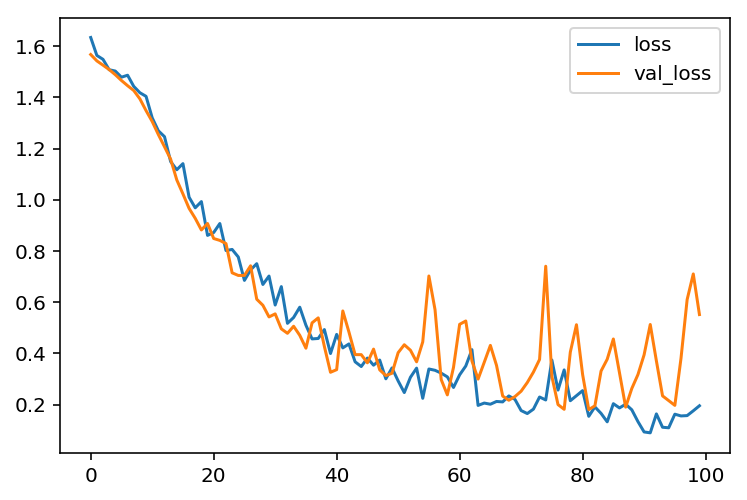

In [19]:
utils.plot_history(history, ['loss', 'val_loss'])

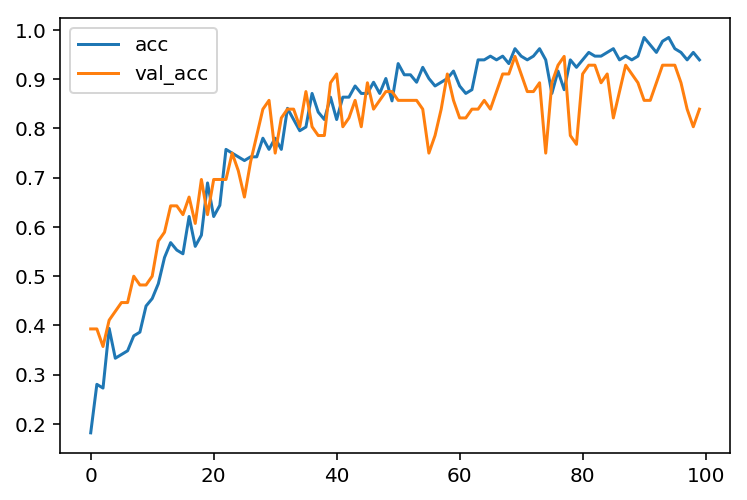

In [20]:
utils.plot_history(history, ['acc', 'val_acc'])

In [21]:
emoji_model.evaluate(train_x, train_y)
emoji_model.evaluate(test_x, test_y)

56/56 [==============================] - 0s 124us/sample - loss: 0.5516 - acc: 0.8393


[0.5516404466969627, 0.83928573]

## Save and Load Models

In [22]:
# import 
import h5py

Two parts need to be saved inorder to use the model in prod:
1. Neural Network Structure 
2. Trained Weights (Matrix)
We will save them separately. This makes it easy to manage multiple versions of weights and you can always choose which version to go for production.

In [23]:
import os

model_root = 'resources/emoji_model'
os.makedirs(model_root, exist_ok = True)

In [24]:
# Save model structure as json
with open(os.path.join(model_root, "network.json"), "w") as fp:
    fp.write(emoji_model.to_json())
    
# Save model weights 
emoji_model.save_weights(os.path.join(model_root, "weights.h5"))

Download and load a pretrained model

In [25]:
network_path, weights_path = utils.download_best_emoji_model()

start downloading...
start extracting compressed files...
data files are now available at resources/emoji_model_best


In [28]:
from tensorflow.keras.models import model_from_json

# Load model structure 
with open(network_path, "r") as fp:
    emoji_model_best = model_from_json(fp.read())
    
# Load model weights 
emoji_model_best.load_weights(weights_path)

In [29]:
emoji_model_best.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [30]:
emoji_model_best.evaluate(train_x, train_y)
emoji_model_best.evaluate(test_x, test_y)

56/56 [==============================] - 0s 135us/sample - loss: 0.2815 - acc: 0.9286


[0.2815132737159729, 0.9285714]

In [33]:
def predict(text):
    x = utils.sentences_to_indices(
        np.array([text]),
        word_to_index,
        maxlen)
    probs = emoji_model_best.predict(x)
    pred = np.argmax(probs)
    print(text, utils.label_to_emoji(pred))

In [34]:
predict('I am not feeling happy')

I am not feeling happy 😞
